In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import os
os.chdir('../..')

In [3]:
import importlib
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import os
from matplotlib import rcParams
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

MATPLOT_STYLE = './code/mplrc'
FONT_FOLDER = '/Users/alelouis/Library/Fonts'
FONT = 'JetBrains Mono'
IGNORES = ['__pycache__', '.ipynb_checkpoints']
STATIC_PATH = './static/images/'


def ignore(f, ignores):
    return not any([ignore in f.path for ignore in ignores])


mpl.rc_file(MATPLOT_STYLE)
font_dir = [FONT_FOLDER]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
rcParams['font.family'] = FONT

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import string

from collections import Counter

In [5]:
path = "/Users/alelouis/Projects/alelouis-site/static/images/entropy"

In [6]:
# util functions
information = lambda p: -np.log2(p)
entropy = lambda p: np.sum(p * information(p))

In [7]:
# read lyrics file
c = Counter(''.join(open("./code/entropy/lyrics", "r").readlines()).replace('\n','').replace(' ','').replace(',','').lower())

In [8]:
# letter distribution
d = sorted(dict(c).items(), key=lambda x:x[1])[::-1]

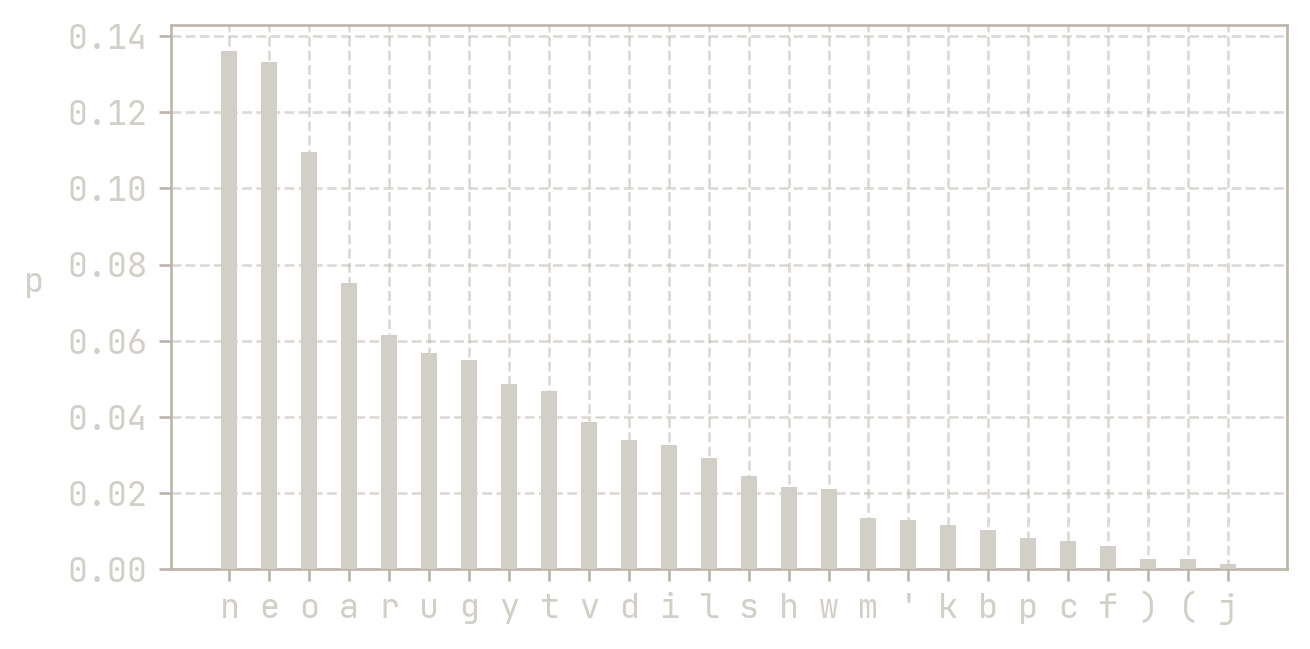

In [22]:
# plot letter distribution
plt.figure(dpi=120, figsize = (6, 3))
x = [k[0] for k in d]
y = [v[1] for v in d]
plt.bar(x, list(map(lambda l: l/sum(y), y)), zorder = 10, width = 0.4)
plt.ylabel("p", rotation = 0, labelpad=10)
plt.grid(which="minor", linestyle = ":", alpha = 0.5)
plt.grid(which="major", linestyle = "--", alpha = 0.5)
#plt.savefig(path + '/prob.svg', bbox_inches = "tight")

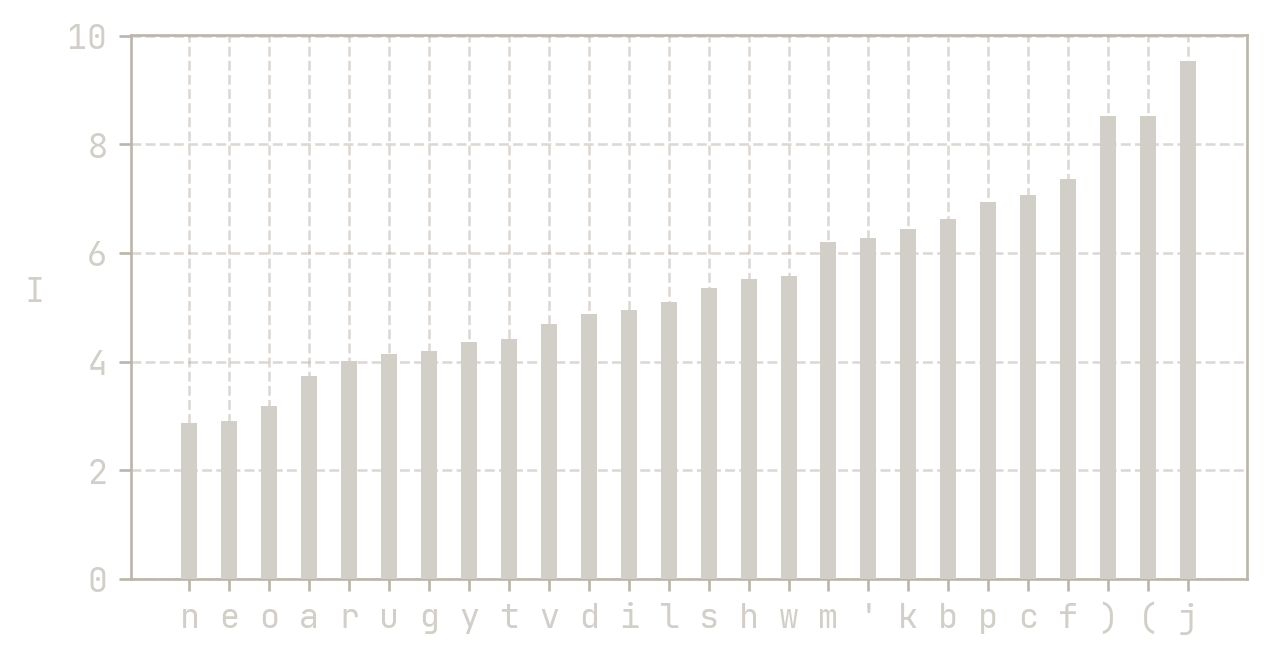

In [23]:
# plot letter information
plt.figure(dpi=120, figsize = (6, 3))
x = [k[0] for k in d]
y = [v[1] for v in d]
p = list(map(lambda l: l/sum(y), y))
i = list(map(lambda pr: -np.log2(pr), p))
plt.bar(x, i, zorder = 10, width = 0.4)
plt.ylabel("I", rotation = 0, labelpad=10)
plt.grid(which="minor", linestyle = ":", alpha = 0.5)
plt.grid(which="major", linestyle = "--", alpha = 0.5)
#plt.savefig(path + '/information.svg', bbox_inches = "tight")

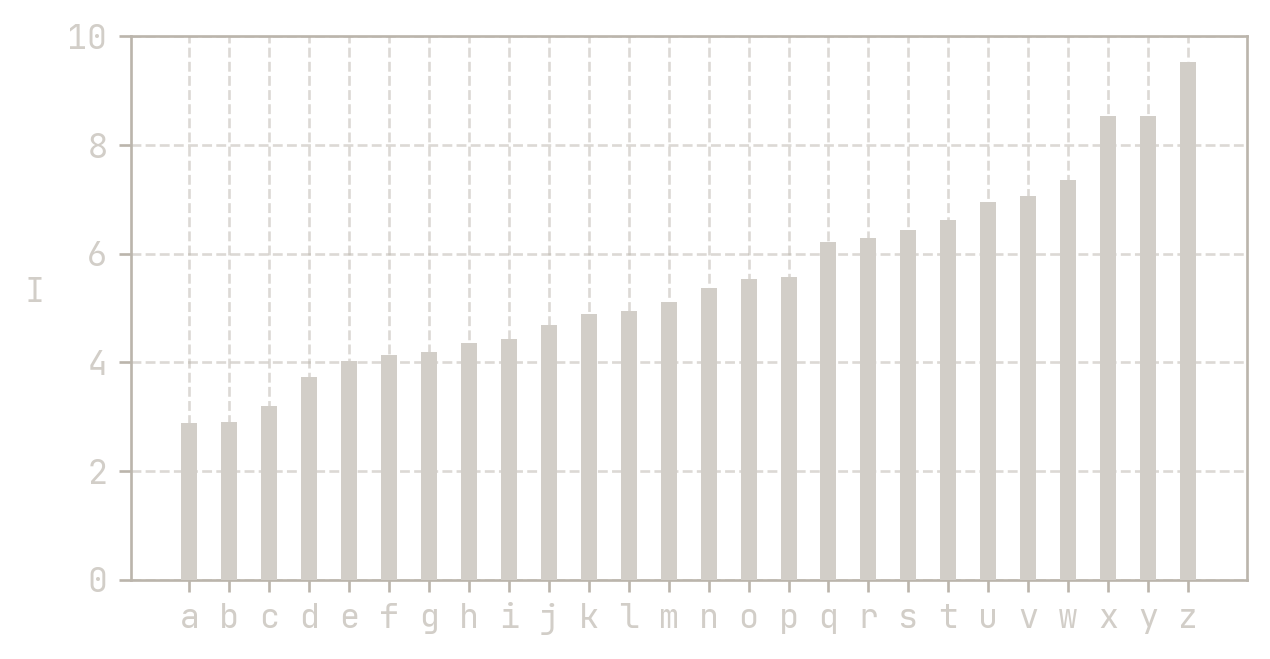

In [24]:
# plot attributes information
plt.figure(dpi=120, figsize = (6, 3))
x = list(string.ascii_lowercase)
y = [v[1] for v in d]
p = list(map(lambda l: l/sum(y), y))
i = list(map(lambda pr: -np.log2(pr), p))
plt.bar(x, i, zorder = 10, width = 0.4)
plt.ylabel("I", rotation = 0, labelpad=10)
plt.grid(which="minor", linestyle = ":", alpha = 0.5)
plt.grid(which="major", linestyle = "--", alpha = 0.5)
#plt.savefig(path + '/attributes.svg', bbox_inches = "tight")

In [25]:
def get_character(prob, attr):
    # Sample a characters with attributes without replacement
    return list(np.random.choice(a = attr, size = 5, p = prob, replace = False))

def ask_question():
    # Sample a question
    q = np.random.choice(a = attr)
    print(f'Do you have {q}?')
    return q

def get_answer(q, character):
    # Check if q is in characters
    ans = q in character
    print("Yes" if ans else "No")
    return ans

def get_prob_of_attr(attr, characters):
    # Get probability of attr in characters
    return sum(attr in c for c in characters) / len(characters)

def get_entropies(current_characters):
    # Compute entropy of all attributes
    entropies = {}
    for a in attr:
        informations = []
        for c in current_characters:
            p = get_prob_of_attr(a, current_characters)
            informations.append(information(p if a in c else 1-p))
        entropies.update({a : sum(informations)/len(informations)})
    return sorted(dict(entropies).items(), key=lambda x:x[1])[::-1]

def get_entropies_all(current_characters):
    # Other way, same result
    entropies = {}
    for a in attr:
        p = get_prob_of_attr(a, current_characters)
        entropies.update({a : p*information(p)+(1-p)*information(1-p)})
    return sorted(dict(entropies).items(), key=lambda x:x[1])[::-1]

def empirical_entropy(q):
    # Compute average info for 1000 samples, should be equal to entropy
    infos = []
    for mc in range(1000):
        character_to_find = characters[np.random.randint(len(characters))]
        a = get_answer(q, character_to_find)
        p = get_prob_of_attr(q, characters)
        infos.append(information(p if a else 1-p))
    return np.mean(infos)

In [26]:
# Create characters
prob = list(map(lambda l: l/sum(y), [v[1] for v in d]))
attr = list(string.ascii_lowercase)
characters = [get_character(prob, attr) for _ in range(20)]

In [27]:
%%capture
he_o = empirical_entropy('b')
h_o = get_entropies(characters)

In [54]:
%%capture
# Play many games game with entropy strategy
iterations = []
for games in range(100):
    current_characters = characters
    character_to_find = characters[np.random.randint(len(characters))]
    it = 0
    while len(current_characters)>1:
        it += 1
        entropies = get_entropies(current_characters)
        q = entropies[0][0]
        print(f'> Do you have {q} ?')
        a = get_answer(q, character_to_find)
        p = get_prob_of_attr(q, current_characters)
        print(f'We got {information(p if a else 1-p)} bit(s) of information. ')
        if a: current_characters = [c for c in current_characters if q in c]
        else: current_characters = [c for c in current_characters if q not in c]
        h = entropy(np.ones(len(current_characters))/len(current_characters))
        print(f'Entropy is down to {h:.2f} bit(s).')
    iterations.append(it)

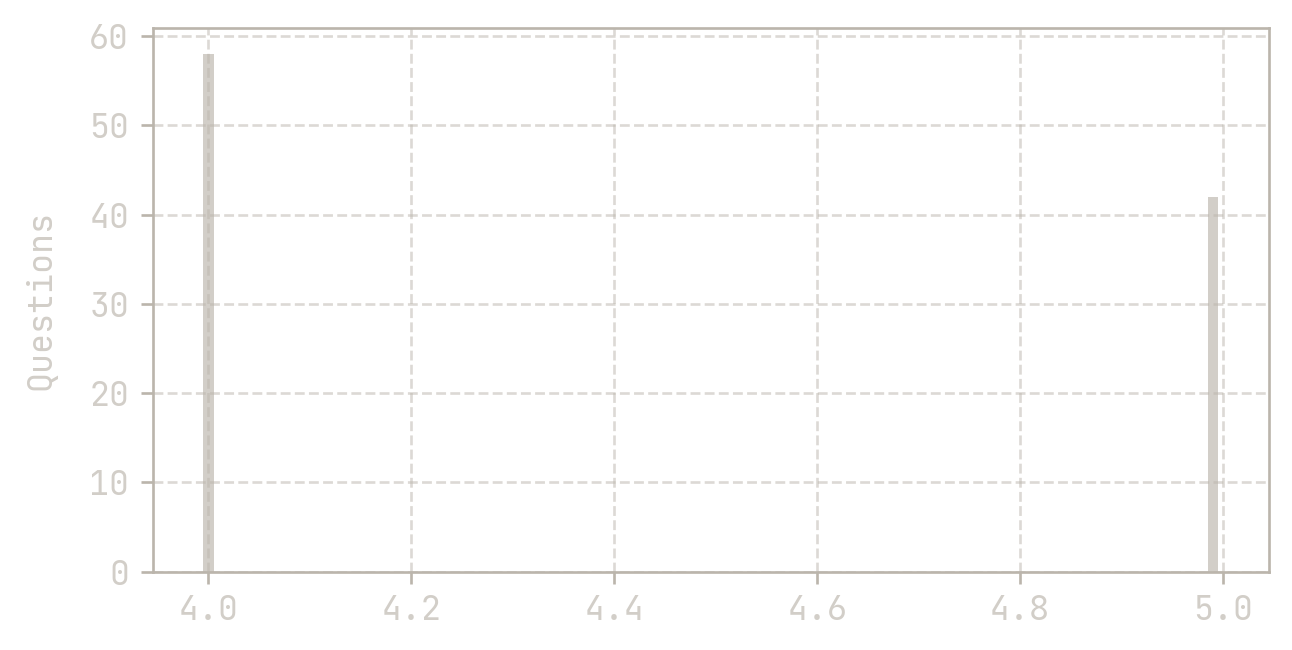

In [59]:
# Plot win stats for entropy stategy
plt.figure(dpi=120, figsize = (6, 3))
plt.hist(iterations, bins = 100, align='left', rwidth=1)
plt.ylabel("Questions", labelpad=10)
plt.grid(which="minor", linestyle = ":", alpha = 0.5)
plt.grid(which="major", linestyle = "--", alpha = 0.5)
#plt.savefig(path + '/question_hist.svg', bbox_inches = "tight")

In [30]:
# Play one game
current_characters = characters
iterations = 0
while len(current_characters)>1:
    iterations += 1
    entropies = get_entropies(current_characters)
    q = entropies[0][0]
    print(f'> Do you have {q} ?')
    a = get_answer(q, character_to_find)
    p = get_prob_of_attr(q, current_characters)
    print(f'We got {information(p if a else 1-p)} bit(s) of information. ')
    if a: current_characters = [c for c in current_characters if q in c]
    else: current_characters = [c for c in current_characters if q not in c]
    h = entropy(np.ones(len(current_characters))/len(current_characters))
    print(f'Entropy is down to {h:.2f} bit(s).')
print(f'Your word was {current_characters[0]} !')

> Do you have e ?
Yes
We got 1.0 bit(s) of information. 
Entropy is down to 3.32 bit(s).
> Do you have a ?
Yes
We got 1.0 bit(s) of information. 
Entropy is down to 2.32 bit(s).
> Do you have i ?
Yes
We got 0.7369655941662062 bit(s) of information. 
Entropy is down to 1.58 bit(s).
> Do you have u ?
Yes
We got 1.5849625007211563 bit(s) of information. 
Entropy is down to 0.00 bit(s).
Your word was ['l', 'e', 'i', 'a', 'u'] !


In [61]:
%%capture
# Play many games game with random strategy
iterations = []
for games in range(1000):
    print(games)
    current_characters = characters
    character_to_find = characters[np.random.randint(len(characters))]
    it = 0
    while len(current_characters)>1:
        it += 1
        entropies = get_entropies(current_characters)
        q = entropies[np.random.randint(len(entropies))][0]
        print(f'> Do you have {q} ?')
        a = get_answer(q, character_to_find)
        p = get_prob_of_attr(q, current_characters)
        print(f'We got {information(p if a else 1-p)} bit(s) of information. ')
        if a: current_characters = [c for c in current_characters if q in c]
        else: current_characters = [c for c in current_characters if q not in c]
        h = entropy(np.ones(len(current_characters))/len(current_characters))
        print(f'Entropy is down to {h:.2f} bit(s).')
    iterations.append(it)

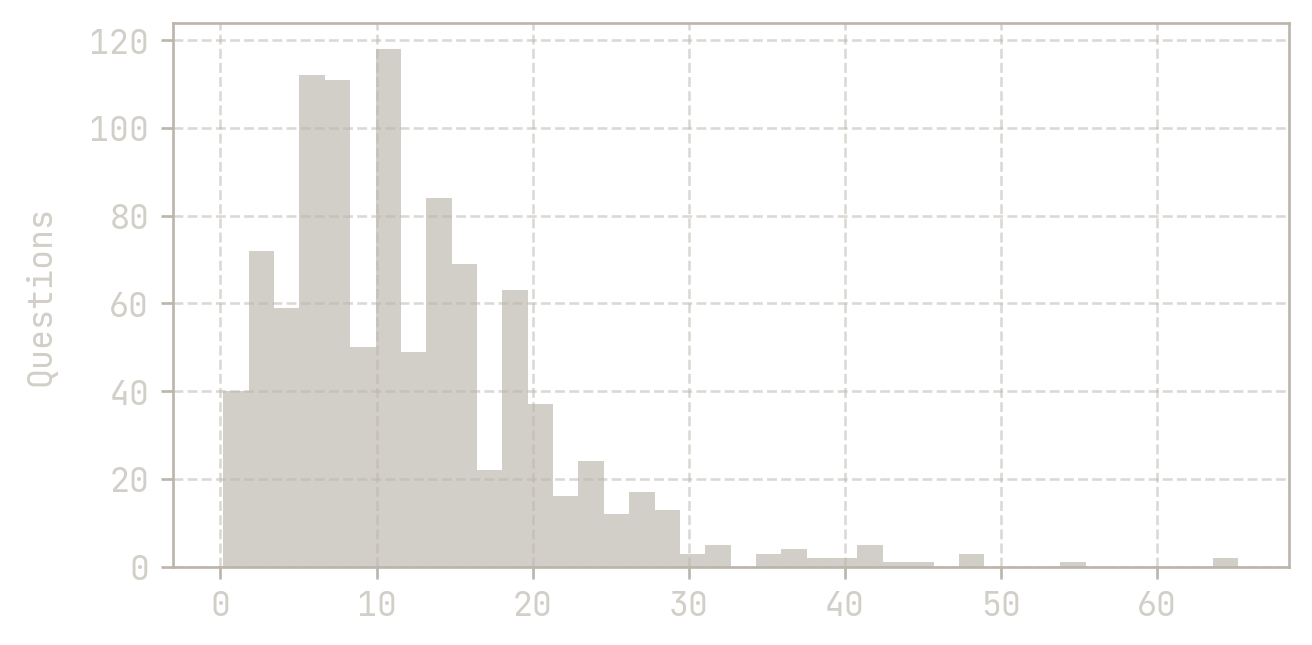

In [63]:
# Plot win stats for random stategy
plt.figure(dpi=120, figsize = (6, 3))
plt.hist(iterations, bins = 40, align='left', rwidth=1)
plt.ylabel("Questions", labelpad=10)
plt.grid(which="minor", linestyle = ":", alpha = 0.5)
plt.grid(which="major", linestyle = "--", alpha = 0.5)
#plt.savefig(path + '/question_hist_random.svg', bbox_inches = "tight")